# Port Seguro's Safe Driver Prediction

## Imports

In [1]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Machine learning
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

# Other
from IPython.display import Image
import configparser
import gc # clear RAM
import subprocess
import warnings
import pprint
import time
import os

---

## Prepare Principal Directory

In [2]:
def prepare_directory_work(end_directory: str='notebooks'):
    # Current path
    curr_dir = os.path.dirname (os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}'

In [3]:
prepare_directory_work(end_directory='notebooks')

'/home/campos/projetos/challenges/kaggle/porto-seguro-safe-driver-prediction/notebooks'

### Prepare Environment

In [5]:
# from <package>.<module> import <class>
from src.environment.prepare_env import *


main()

Requirements this project:

pandas==0.24.2
numpy==1.16.4
lightgbm==2.2.3
missingno==0.4.1
seaborn==0.9.0
matplotlib==3.1.1
catboost==0.15.2
xgboost==0.71
ipython==7.6.1
scikit_learn==0.21.2
atlas==0.27.0

--------------------------------------------------
Configuration Environment:

OS:
Linux
Distributor ID:	Ubuntu
Description:	Ubuntu 19.04
Release:	19.04
Codename:	disco

Python Version:
Python 3.7.3

Pip Version:
pip 19.1.1 from /home/campos/projetos/challenges/kaggle/porto-seguro-safe-driver-prediction/src/environment/venv/lib/python3.7/site-packages/pip (python 3.7)

Jupyter Version:
4.4.0

--------------------------------------------------

Disk Usage:

data:
383M	data/

virtual env:
736M	src/environment/venv/

all:
1,3G	.

--------------------------------------------------
Structure This Project:

.
├── data
│   ├── kaggle_submission.csv
│   └── raw
│       ├── datasets.zip
│       ├── sample_submission.csv
│       ├── test.csv
│       └── train.csv
├── LICENSE
├── notebooks
│   └

### Cell Format
Cell format graphics and tables.

In [92]:
# Guarantees visualization inside the jupyter
%matplotlib inline

# formata os dados de todas as tabelas (ponto flutuante com 2 casas)
pd.options.display.float_format = '{:.2f}'.format

# param config
rc={'savefig.dpi': 500, 
    'figure.autolayout': False, 
    'figure.figsize': [15, 8], 
    'axes.labelsize': 18,
    'axes.titlesize': 18, 
    'font.size': 18, 
    'lines.linewidth': 2.0, 
    'lines.markersize': 8, 
    'legend.fontsize': 16,
    'xtick.labelsize': 16, 
    'ytick.labelsize': 16}

# Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

# Definition color and map de colors
default_color = '#56B4E9'
colormap = plt.cm.cool

# Single colour palettes for good and bad outcomes
good_palette = ['#44cc44']
bad_palette = ['#cc4444']
# Colour palette for gender - traditional light pink (female), light blue (male)
gender_palette = ['#B0C4DE','#FFB6C1']
# Colour palette for ticket class - gold (first), silver (second), bronze (third)
class_palette = ['#FFD700','#C0C0C0','#CD7F32']

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# graph style
sns.set(style='dark',rc=rc)

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# Pretty print
pp = pprint.PrettyPrinter(indent=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## Meta-data
In this competition, you will predict the probability that an auto insurance policy holder files a claim.
In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal.
- Values of -1 indicate that the feature was _missing_ from the observation.
- `target` columns signifies whether or not a claim was filed for that policy holder.
- `Ind` is related to individual or driver
- `reg` is related to region
- `car` is related to car itself
- `calc` is an calculated feature


## File descriptions
- `train.csv` contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.
- `test.csv` contains the test data.
- `sample_submission.csv` is submission file showing the correct format.




## Loding files

In [93]:
%%time

# sep=','
# na_values = valores nulos
# encoding='utf-8'

train = pd.read_csv('data/raw/train.csv', 
                    na_values=-1,
                    sep=',',
                    encoding='utf-8')
test = pd.read_csv('data/raw/test.csv', 
                   na_values=-1,
                   sep=',',
                   encoding='utf-8')

CPU times: user 7.15 s, sys: 496 ms, total: 7.64 s
Wall time: 7.65 s


---

## Data Exploration 

In [94]:
# Required column for kaggle submition
id_test = test['id'].values

In [95]:
print(train.shape)
print(test.shape)

(595212, 59)
(892816, 58)


In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     594996 non-null float64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595129 non-null float64
ps_ind_05_cat     589403 non-null float64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64

In [97]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 58 columns):
id                892816 non-null int64
ps_ind_01         892816 non-null int64
ps_ind_02_cat     892509 non-null float64
ps_ind_03         892816 non-null int64
ps_ind_04_cat     892671 non-null float64
ps_ind_05_cat     884106 non-null float64
ps_ind_06_bin     892816 non-null int64
ps_ind_07_bin     892816 non-null int64
ps_ind_08_bin     892816 non-null int64
ps_ind_09_bin     892816 non-null int64
ps_ind_10_bin     892816 non-null int64
ps_ind_11_bin     892816 non-null int64
ps_ind_12_bin     892816 non-null int64
ps_ind_13_bin     892816 non-null int64
ps_ind_14         892816 non-null int64
ps_ind_15         892816 non-null int64
ps_ind_16_bin     892816 non-null int64
ps_ind_17_bin     892816 non-null int64
ps_ind_18_bin     892816 non-null int64
ps_reg_01         892816 non-null float64
ps_reg_02         892816 non-null float64
ps_reg_03         731132 non-null float

In [98]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.00,5,1.00,0.00,0,1,0,0,0,0,0,0,0,11,0,1,0,0.70,0.20,0.72,10.00,1.00,nan,0,1.00,4,1.00,0,0.00,1,12,2.00,0.40,0.88,0.37,3.61,0.60,0.50,0.20,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.00,7,0.00,0.00,0,0,1,0,0,0,0,0,0,3,0,0,1,0.80,0.40,0.77,11.00,1.00,nan,0,nan,11,1.00,1,2.00,1,19,3.00,0.32,0.62,0.39,2.45,0.30,0.10,0.30,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.00,9,1.00,0.00,0,0,1,0,0,0,0,0,0,12,1,0,0,0.00,0.00,nan,7.00,1.00,nan,0,nan,14,1.00,1,2.00,1,60,1.00,0.32,0.64,0.35,3.32,0.50,0.70,0.10,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.00,2,0.00,0.00,1,0,0,0,0,0,0,0,0,8,1,0,0,0.90,0.20,0.58,7.00,1.00,0.00,0,1.00,11,1.00,1,3.00,1,104,1.00,0.37,0.54,0.29,2.00,0.60,0.90,0.10,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.00,0,1.00,0.00,1,0,0,0,0,0,0,0,0,9,1,0,0,0.70,0.60,0.84,11.00,1.00,nan,0,nan,14,1.00,1,2.00,1,82,3.00,0.32,0.57,0.37,2.00,0.40,0.60,0.00,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [99]:
test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1.00,8,1.00,0.00,0,1,0,0,0,0,0,0,0,12,1,0,0,0.50,0.30,0.61,7.00,1.00,nan,0,nan,1,1.00,1,2.00,1,65,1.00,0.32,0.67,0.35,3.46,0.10,0.80,0.60,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2.00,5,1.00,0.00,0,0,0,1,0,0,0,0,0,5,1,0,0,0.90,0.50,0.77,4.00,1.00,nan,0,0.00,11,1.00,1,0.00,1,103,1.00,0.32,0.61,0.36,2.83,0.40,0.50,0.40,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1.00,3,0.00,0.00,0,0,0,1,0,0,0,0,0,10,0,0,0,0.40,0.00,0.92,11.00,1.00,nan,0,nan,14,1.00,1,2.00,1,29,3.00,0.40,0.90,0.40,3.32,0.60,0.60,0.60,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1.00,6,0.00,0.00,1,0,0,0,0,0,0,0,0,4,1,0,0,0.10,0.20,nan,7.00,1.00,nan,0,nan,1,1.00,1,2.00,1,40,2.00,0.37,0.65,0.38,2.45,0.10,0.50,0.50,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1.00,7,0.00,0.00,0,0,0,1,0,0,0,0,0,4,1,0,0,0.90,0.40,0.82,11.00,1.00,nan,0,nan,11,1.00,1,2.00,1,101,3.00,0.37,0.81,0.39,3.32,0.90,0.60,0.80,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1


## Target Analisys
This column signifies whether or not a claim was filed for that policy holder.
- Go claim
- Dont claim

**OBS:** never use target how feature

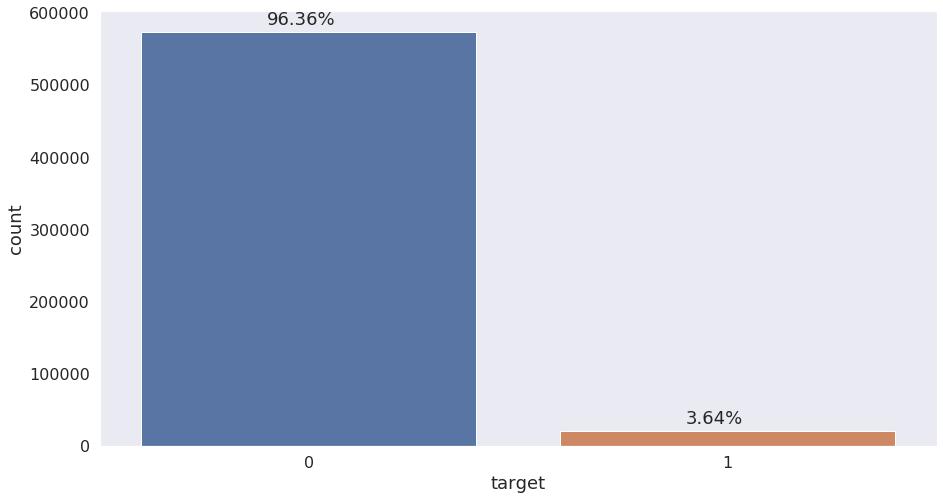

In [100]:
plt.figure(figsize=(15,8))

# faz um agrupamento da coluna 'target'
ax = sns.countplot('target', data=train)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(train['target'])), 
                (p.get_x() + 0.3, p.get_height() + 10000))

Only 3.64% a clain

---

## Data Analysis

In [101]:
def get_meta(train):
    data = []
    for col in train.columns:
        # Defining the role
        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'input'

        # Defining the level
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col or col == 'id':
            level = 'nominal'
        elif train[col].dtype == np.float64:
            level = 'interval'
        elif train[col].dtype == np.int64:
            level = 'ordinal'

        # Initialize keep to True for all variables except for id
        keep = True
        if col == 'id':
            keep = False

        # Defining the data type 
        dtype = train[col].dtype

        # Creating a Dict that contains all the metadata for the variable
        col_dict = {
            'varname': col,
            'role'   : role,
            'level'  : level,
            'keep'   : keep,
            'dtype'  : dtype
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
    meta.set_index('varname', inplace=True)
    return meta

In [102]:
meta_data = get_meta(train)
display(meta_data)

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,float64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,float64
ps_ind_05_cat,input,nominal,True,float64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [103]:
meta_counts = meta_data\
                    .groupby(['role', 'level'])\
                        .agg({'dtype': lambda x: x.count()})\
                            .reset_index()
display(meta_counts)

,role,level,dtype
0,id,nominal,1
1,input,binary,17
2,input,interval,11
3,input,nominal,14
4,input,ordinal,15
5,target,binary,1


[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Variable Type'),
 Text(0.5, 1.0, 'Variables Count Across Datatype')]

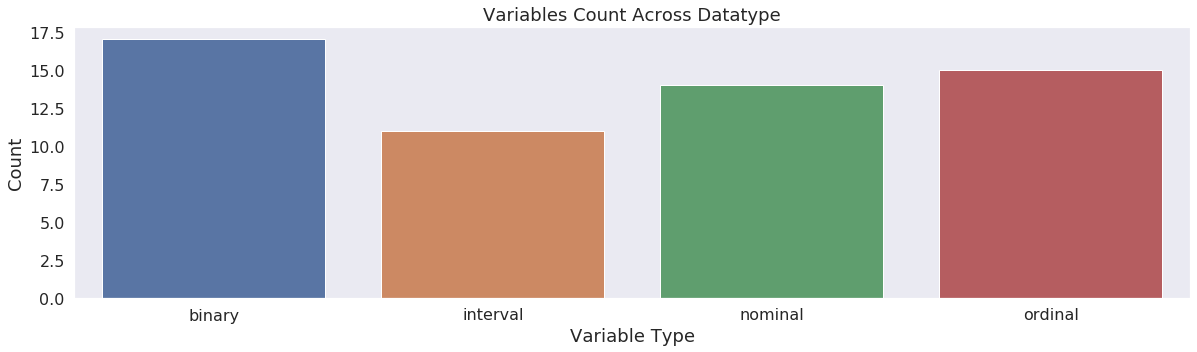

In [104]:
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.barplot(data=meta_counts[(meta_counts.role != 'target') & (meta_counts.role != 'id') ],
            x="level",
            y="dtype",
            ax=ax)

ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

In [105]:
col_ordinal   = meta_data[(meta_data.level == 'ordinal') & (meta_data.keep)].index
col_nominal   = meta_data[(meta_data.level == 'nominal') & (meta_data.keep)].index
col_internval = meta_data[(meta_data.level == 'interval') & (meta_data.keep)].index
col_binary    = meta_data[(meta_data.level == 'binary') & (meta_data.keep) & (meta_data.role != 'target')].index

---

# Missing Values

In [106]:
# return TRUE if column contains one or more values missing
train.isnull().any()

id                False
target            False
ps_ind_01         False
ps_ind_02_cat      True
ps_ind_03         False
ps_ind_04_cat      True
ps_ind_05_cat      True
ps_ind_06_bin     False
ps_ind_07_bin     False
ps_ind_08_bin     False
ps_ind_09_bin     False
ps_ind_10_bin     False
ps_ind_11_bin     False
ps_ind_12_bin     False
ps_ind_13_bin     False
ps_ind_14         False
ps_ind_15         False
ps_ind_16_bin     False
ps_ind_17_bin     False
ps_ind_18_bin     False
ps_reg_01         False
ps_reg_02         False
ps_reg_03          True
ps_car_01_cat      True
ps_car_02_cat      True
ps_car_03_cat      True
ps_car_04_cat     False
ps_car_05_cat      True
ps_car_06_cat     False
ps_car_07_cat      True
ps_car_08_cat     False
ps_car_09_cat      True
ps_car_10_cat     False
ps_car_11_cat     False
ps_car_11          True
ps_car_12          True
ps_car_13         False
ps_car_14          True
ps_car_15         False
ps_calc_01        False
ps_calc_02        False
ps_calc_03      

In [107]:
missingValueColumns = train.columns[train.isnull().any()].tolist()

# cria um dataframe so com valores missing
df_null = train[missingValueColumns]

In [108]:
pp.pprint(missingValueColumns)

[   'ps_ind_02_cat',
    'ps_ind_04_cat',
    'ps_ind_05_cat',
    'ps_reg_03',
    'ps_car_01_cat',
    'ps_car_02_cat',
    'ps_car_03_cat',
    'ps_car_05_cat',
    'ps_car_07_cat',
    'ps_car_09_cat',
    'ps_car_11',
    'ps_car_12',
    'ps_car_14']


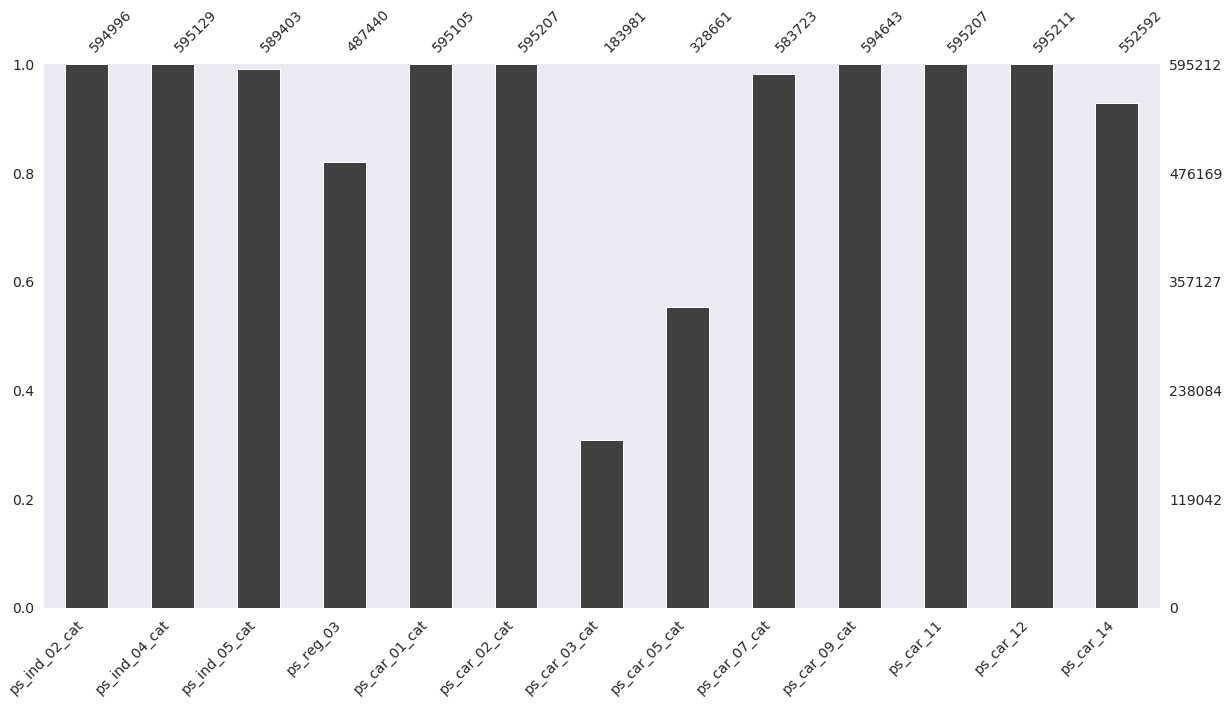

In [109]:
# show a quantidade de missing por columns
msno.bar(df_null,figsize=(20,10), fontsize=14, labels=True, color=(0.25, 0.25, 0.25))

## Correlations Between Missing Values

- Very important analysis missing values.
- Simple solution: `values_missing = -1`

### Heatmap

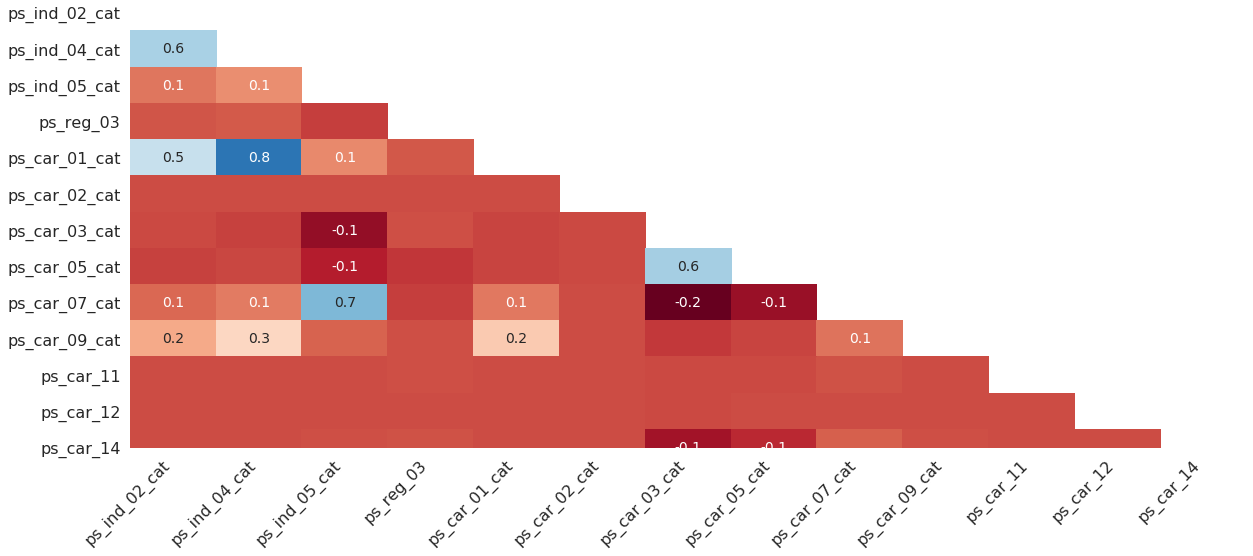

In [110]:
msno.heatmap(df_null,figsize=(20,8))

### Dendrogram

- Denogram is used to visualize correlations
- The depth (y-axis) indicates the correlation between the variables
- _ps_car_01_cat_ is highly correlated with _ps_ind_04_cat_ because (axis Y = 0)

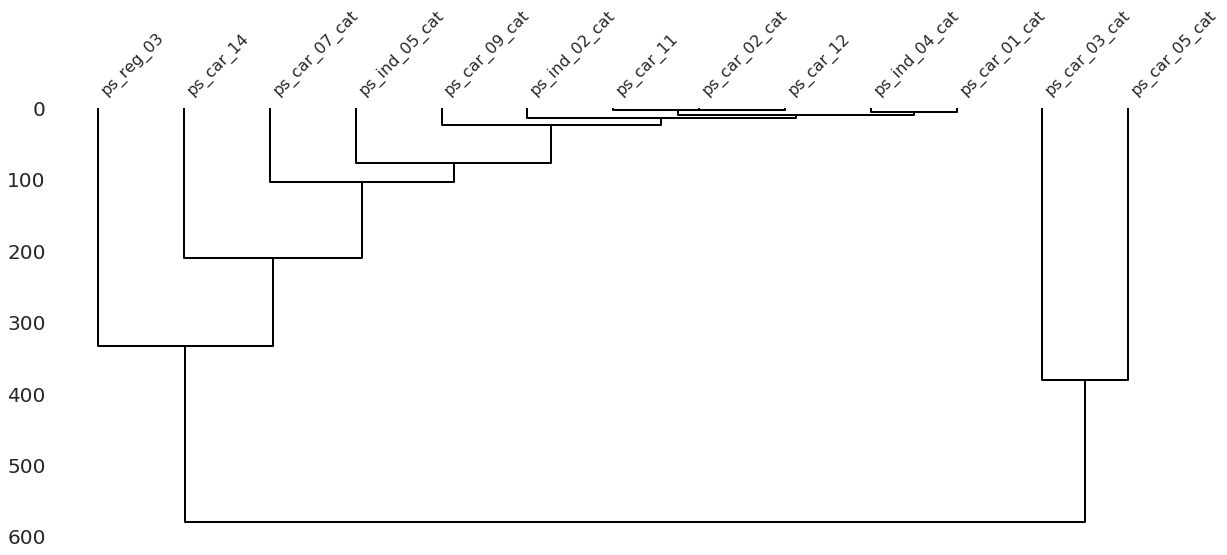

In [111]:
msno.dendrogram(df_null, figsize=(20,8))

### Distribuiton of Columns with Missing Values

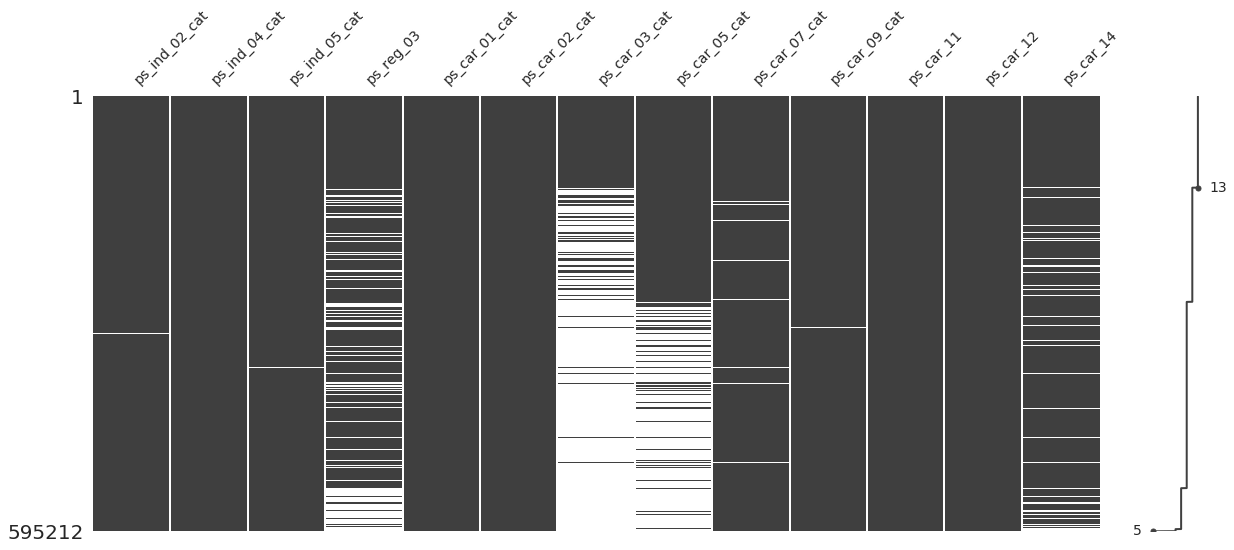

In [112]:
sorted_data = msno.nullity_sort(df_null, sort='descending')
msno.matrix(sorted_data, figsize=(20,8), fontsize=14, color=(0.25, 0.25, 0.25))

---

## Correlation Pearson

- if two variables = 1 so it's colinear, in this case the variables are the same thing and possibly **only have different names.**

In [113]:
display(col_internval)

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12',
       'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02',
       'ps_calc_03'],
      dtype='object', name='varname')

In [114]:
corr_matrix = train[col_internval].corr()
display(corr_matrix)

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
ps_reg_01,1.00,0.47,0.19,0.08,0.02,0.03,-0.00,0.00,-0.00,0.00,-0.00
ps_reg_02,0.47,1.00,0.74,0.07,0.17,0.19,0.06,0.05,0.00,-0.00,0.00
ps_reg_03,0.19,0.74,1.00,0.05,0.23,0.26,0.09,0.09,0.00,-0.00,0.00
ps_car_11,0.08,0.07,0.05,1.00,0.06,0.10,-0.04,0.11,0.00,0.00,-0.00
ps_car_12,0.02,0.17,0.23,0.06,1.00,0.67,0.60,0.05,-0.00,-0.00,0.00
ps_car_13,0.03,0.19,0.26,0.10,0.67,1.00,0.46,0.53,0.00,0.00,-0.00
ps_car_14,-0.00,0.06,0.09,-0.04,0.60,0.46,1.00,0.01,-0.00,-0.00,-0.00
ps_car_15,0.00,0.05,0.09,0.11,0.05,0.53,0.01,1.00,0.00,-0.00,-0.00
ps_calc_01,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,1.00,-0.00,0.00
ps_calc_02,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,1.00,0.00


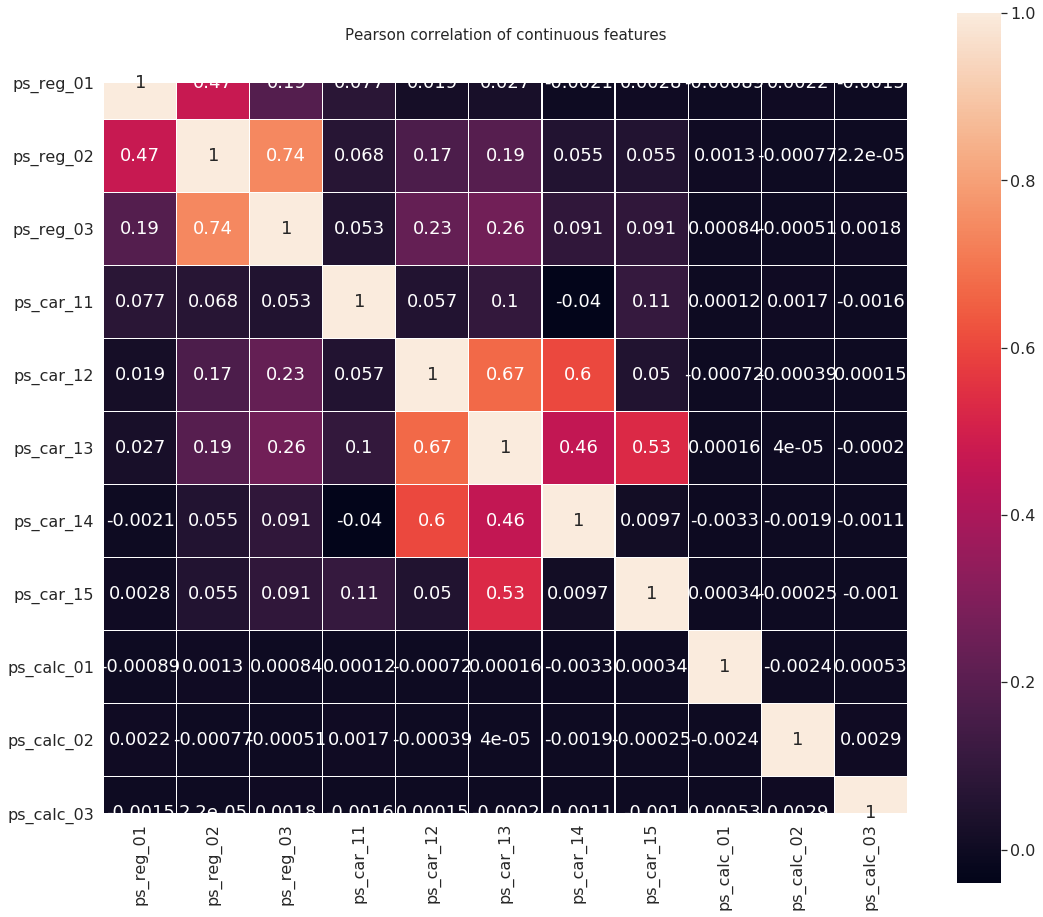

In [115]:
plt.figure(figsize=(18,16))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train[col_internval].corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            linecolor='white', 
            annot=True)

In [116]:
# fill all missing values with (-1)
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

---

## Feature Importance
 - Detect problems of importance

In [117]:
def get_feature_importance_df(feature_importances,
                              column_names, 
                              top_n=25):
    """Get feature importance data frame.
 
    Parameters
    ----------
    feature_importances : numpy ndarray
        Feature importances computed by an ensemble 
            model like random forest or boosting
    column_names : array-like
        Names of the columns in the same order as feature 
            importances
    top_n : integer
        Number of top features
 
    Returns
    -------
    df : a Pandas data frame"""
     
    imp_dict = dict(zip(column_names, feature_importances))
    
    # get name features sroted
    top_features = sorted(imp_dict, key=imp_dict.get, reverse=True)[0:top_n]
    
    # get values
    top_importances = [imp_dict[feature] for feature in top_features]
    
    # create dataframe with feature_importance
    df = pd.DataFrame(data={'feature': top_features, 'importance': top_importances})
    return df

In [118]:
# create model
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=150, # numbers tree
                            max_depth=8,
                            min_samples_leaf=4,
                            max_features=0.2, # each tree utility 20% in the features
                            n_jobs=-1,
                            random_state=42)

In [119]:
# trainning model
rf.fit(train.drop(['target'], axis=1), train.target)
features = train.drop(['target'], axis=1).columns.values
print("---Traing Done---")

---Traing Done---


In [120]:
# get trained model (rf) and avalible the feature_importance
feature_importance = get_feature_importance_df(rf.feature_importances_, features)

# print 25 feature_importance in the rf randomForest
feature_importance

,feature,importance
0,ps_car_13,0.13
1,ps_ind_05_cat,0.07
2,ps_reg_03,0.07
3,ps_ind_17_bin,0.06
4,ps_ind_03,0.04
5,ps_reg_02,0.04
6,id,0.04
7,ps_car_07_cat,0.03
8,ps_car_04_cat,0.03
9,ps_car_14,0.03


[Text(0, 0.5, 'Importance'),
 Text(0.5, 0, 'Variable name'),
 Text(0.5, 1.0, 'Variable importances')]

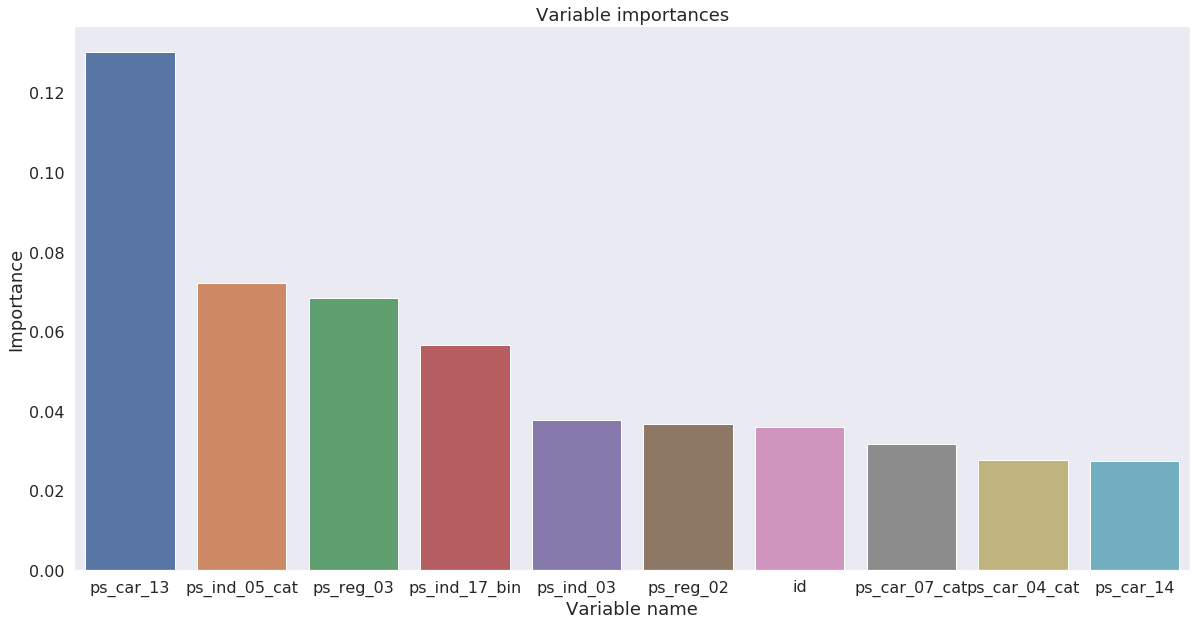

In [121]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(data=feature_importance[:10], 
            x="feature", 
            y="importance", 
            ax=ax)
ax.set(xlabel='Variable name',
       ylabel='Importance',
       title="Variable importances")

In [122]:
def get_without_importance(df_feature_importance: 'dataframe') -> list:
    list_drop_col = []
              
    cond_duracao = (df_feature_importance['importance'] < 0.01)
    df_temp = df_feature_importance[cond_duracao]
    
    list_drop_col = df_temp['feature'].tolist()
    
    print("-"*25, "FEATURE WITHOUT IMPORTANCE", "-"*25, end='\n\n')
    print(df_temp)
    return list_drop_col

In [123]:
def remove_without_importace(df: 'dataframe', list_without_imp: list) -> int:
    print(f'Columns before = {df.shape[1]}')
    
    for column in list_without_imp:
        del df[column]
        
    return print(f"Columns after = {df.shape[1]}")

In [124]:
list_without_importance = get_without_importance(df_feature_importance = feature_importance)

------------------------- FEATURE WITHOUT IMPORTANCE -------------------------

Empty DataFrame
Columns: [feature, importance]
Index: []


---

## Baseline Models

Start base_line be **very simple**:    
- missing_values = -1
- E.g: logistic_regression, random_forest, median

In [73]:
def cross_val_model(X,y, model, n_splits=3):
    'Do split dataset and calculate cross_score'
    X = np.array(X)
    y = np.array(y)
    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2017).split(X, y))

    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='roc_auc')
        print("    cross_score: %.5f" % cross_score.mean())

### Random Forest Model

- Each tree have your dataset and features

In [74]:
#RandomForest params
rf_params = {}
rf_params['n_estimators'] = 200
rf_params['max_depth'] = 6
rf_params['min_samples_split'] = 70
rf_params['min_samples_leaf'] = 30 # end tree necessary 30 leaf
rf_params['n_jobs'] = -1 # run all process

In [75]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [76]:
# create model
rf_model = RandomForestClassifier(**rf_params)

# training model
X = train.drop('target',axis=1)
y = train['target']

In [77]:
# split dataset and calculate cross_score
cross_val_model(X, y, rf_model)

Fit RandomForestClassifier fold 1
    cross_score: 0.62469
Fit RandomForestClassifier fold 2
    cross_score: 0.60661
Fit RandomForestClassifier fold 3
    cross_score: 0.57844


## XGBoost Model
- Model very robust
- descentent gradient 
- regularization parameter: help avoid overfitting
- parallelizable

In [78]:
# XGBoost params
xgb_params = {}
xgb_params['learning_rate'] = 0.02
xgb_params['n_estimators'] = 100
xgb_params['max_depth'] = 6
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9

In [79]:
# create model
XGB_model = XGBClassifier(**rf_params)

# training model
X = train.drop('target',axis=1)
y = train['target']

In [80]:
cross_val_model(X, y, XGB_model)

Fit XGBClassifier fold 1
    cross_score: 0.55513
Fit XGBClassifier fold 2
    cross_score: 0.58326
Fit XGBClassifier fold 3
    cross_score: 0.54446


In [81]:
# Check columns train (X) equals in dataframe test
column = X.columns
test = test[column]

---


## Storage Data Cleaning

In [125]:
def save_data_clenning(df: 'dataframe' = None,
                       path: str = 'data/cleansing/') -> None:
    df.to_csv(path_or_buf = path,
              sep = ',',
              index = False,
              encoding = 'utf8')
    
    return "Data storage!"

In [127]:
submission = pd.DataFrame(columns=['id', 'target'])
submission['id'] = id_test
submission['target'] = rf_model.predict_proba(test)[:, 1] # get all rows in the column 'id'

save_data_clenning(df = submission,
                   path = 'data/kaggle_submission.csv')

'Data storage!'

---

#### Copyright
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">
    <img alt="Creative Commons License" align="right" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" />

This work by Bruno A. R. M. Campos is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.